# 04 - Imbalance Handling Experiments

## Section B & E: Data Engineering & Evaluation

This notebook explores different strategies for handling class imbalance:
1. **Original (imbalanced)** - Baseline performance
2. **Random Undersampling** - Reduce majority class
3. **SMOTE Oversampling** - Synthetic minority samples
4. **Class Weighting** - Cost-sensitive learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('..')

from config import PROCESSED_DATA_DIR, RESULTS_DIR, RANDOM_STATE
from src.sampling import SamplingStrategy, apply_sampling_strategy, compute_class_weights
from src.models import ModelTrainer
from src.evaluation import compute_metrics, evaluate_at_scales
from src.visualization import plot_class_distribution

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print('Imports successful!')

Imports successful!


In [2]:
# Load data
df = pd.read_csv(PROCESSED_DATA_DIR / 'loan_data_processed.csv')

print('='*60)
print('ORIGINAL CLASS DISTRIBUTION')
print('='*60)
print(df['default'].value_counts())
print(f'\nDefault rate: {df["default"].mean()*100:.2f}%')
print(f'Imbalance ratio: 1:{(df["default"]==0).sum() / (df["default"]==1).sum():.2f}')

ORIGINAL CLASS DISTRIBUTION
default
0    1043940
1     262447
Name: count, dtype: int64

Default rate: 20.09%
Imbalance ratio: 1:3.98


In [3]:
# Prepare features
X = df.drop(columns=['default', 'loan_status'], errors='ignore')
y = df['default']

# Encode categorical variables
cat_cols = X.select_dtypes(include=['object', 'string']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Handle missing values
X = X.fillna(X.median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f'Training set: {len(X_train):,} samples')
print(f'Test set: {len(X_test):,} samples')

Training set: 1,045,109 samples
Test set: 261,278 samples


## Strategy 1: Original (No Resampling)

In [4]:
print('\n' + '='*60)
print('STRATEGY 1: ORIGINAL (NO RESAMPLING)')
print('='*60)

rf_original = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_original.fit(X_train, y_train)

y_pred_orig = rf_original.predict(X_test)
y_proba_orig = rf_original.predict_proba(X_test)[:, 1]

print('\nClassification Report:')
print(classification_report(y_test, y_pred_orig, target_names=['Non-Default', 'Default']))
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba_orig):.4f}')


STRATEGY 1: ORIGINAL (NO RESAMPLING)

Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89    208788
     Default       0.53      0.08      0.14     52490

    accuracy                           0.80    261278
   macro avg       0.67      0.53      0.51    261278
weighted avg       0.75      0.80      0.74    261278

ROC-AUC: 0.7024


## Strategy 2: Random Undersampling

In [5]:
print('\n' + '='*60)
print('STRATEGY 2: RANDOM UNDERSAMPLING')
print('='*60)

sampler = SamplingStrategy(random_state=RANDOM_STATE)
X_under, y_under = sampler.random_undersample(X_train, y_train, ratio=1.0)

rf_under = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_under.fit(X_under, y_under)

y_pred_under = rf_under.predict(X_test)
y_proba_under = rf_under.predict_proba(X_test)[:, 1]

print('\nClassification Report:')
print(classification_report(y_test, y_pred_under, target_names=['Non-Default', 'Default']))
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba_under):.4f}')


STRATEGY 2: RANDOM UNDERSAMPLING

--- Random Undersampling ---

Class Distribution:
  Class 0: 835,152 (79.91%)
  Class 1: 209,957 (20.09%)
After undersampling:

Class Distribution:
  Class 0: 209,957 (50.00%)
  Class 1: 209,957 (50.00%)

Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.88      0.64      0.74    208788
     Default       0.32      0.66      0.43     52490

    accuracy                           0.64    261278
   macro avg       0.60      0.65      0.58    261278
weighted avg       0.77      0.64      0.68    261278

ROC-AUC: 0.7063


## Strategy 3: SMOTE Oversampling

In [6]:
print('\n' + '='*60)
print('STRATEGY 3: SMOTE OVERSAMPLING')
print('='*60)

try:
    X_smote, y_smote = sampler.smote_oversample(X_train, y_train)
    
    rf_smote = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_smote.fit(X_smote, y_smote)
    
    y_pred_smote = rf_smote.predict(X_test)
    y_proba_smote = rf_smote.predict_proba(X_test)[:, 1]
    
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred_smote, target_names=['Non-Default', 'Default']))
    print(f'ROC-AUC: {roc_auc_score(y_test, y_proba_smote):.4f}')
except Exception as e:
    print(f'SMOTE failed: {e}')
    y_pred_smote = y_pred_orig
    y_proba_smote = y_proba_orig


STRATEGY 3: SMOTE OVERSAMPLING

--- SMOTE Oversampling ---

Class Distribution:
  Class 0: 835,152 (79.91%)
  Class 1: 209,957 (20.09%)
SMOTE failed: SMOTE.__init__() got an unexpected keyword argument 'n_jobs'


## Strategy 4: Class Weighting

In [7]:
print('\n' + '='*60)
print('STRATEGY 4: CLASS WEIGHTING')
print('='*60)

class_weights = compute_class_weights(y_train)

rf_weighted = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced',
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
rf_weighted.fit(X_train, y_train)

y_pred_weighted = rf_weighted.predict(X_test)
y_proba_weighted = rf_weighted.predict_proba(X_test)[:, 1]

print('\nClassification Report:')
print(classification_report(y_test, y_pred_weighted, target_names=['Non-Default', 'Default']))
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba_weighted):.4f}')


STRATEGY 4: CLASS WEIGHTING

Computed Class Weights:
  Class 0: 0.6257
  Class 1: 2.4889

Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.81      0.99      0.89    208788
     Default       0.53      0.06      0.11     52490

    accuracy                           0.80    261278
   macro avg       0.67      0.52      0.50    261278
weighted avg       0.75      0.80      0.73    261278

ROC-AUC: 0.7026


## Comparison of Strategies

In [8]:
print('\n' + '='*60)
print('STRATEGY COMPARISON')
print('='*60)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

strategies = {
    'Original': (y_pred_orig, y_proba_orig),
    'Undersampling': (y_pred_under, y_proba_under),
    'SMOTE': (y_pred_smote, y_proba_smote),
    'Class Weights': (y_pred_weighted, y_proba_weighted)
}

results = []
for name, (y_pred, y_proba) in strategies.items():
    results.append({
        'Strategy': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

comparison_df = pd.DataFrame(results)
print(comparison_df.to_string(index=False))


STRATEGY COMPARISON
     Strategy  Accuracy  Precision   Recall  F1-Score  ROC-AUC
     Original  0.801181   0.533993 0.081254  0.141045 0.702406
Undersampling  0.644762   0.315408 0.656354  0.426070 0.706293
        SMOTE  0.801181   0.533993 0.081254  0.141045 0.702406
Class Weights  0.800645   0.534557 0.059383  0.106891 0.702605


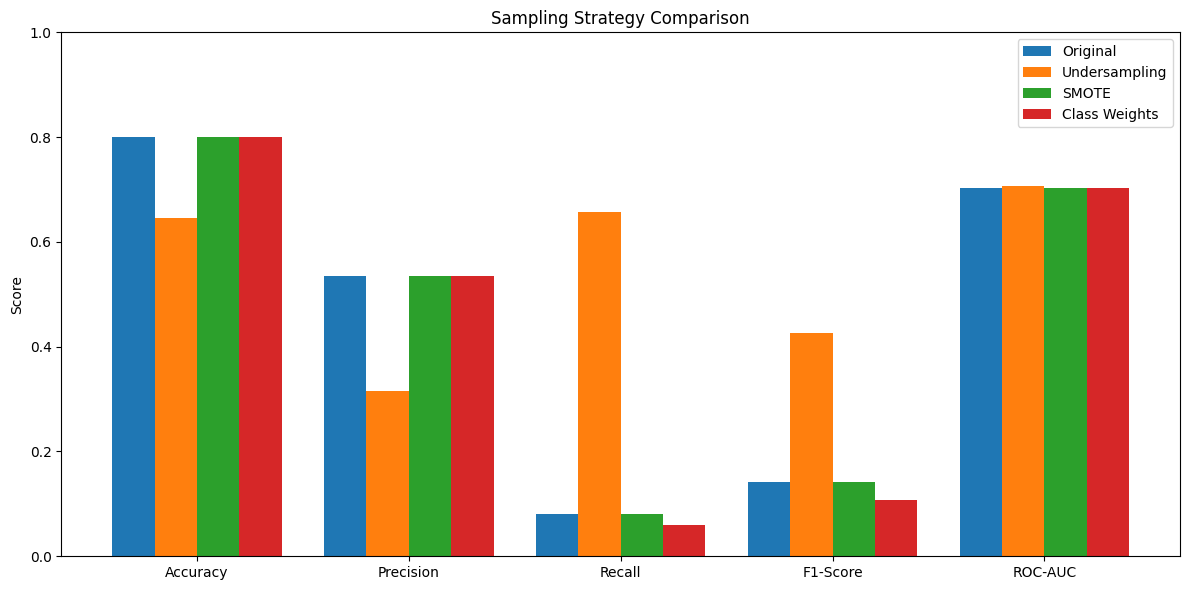

In [9]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2

for i, (name, row) in enumerate(comparison_df.iterrows()):
    values = [comparison_df.loc[i, m] for m in metrics]
    ax.bar(x + i*width, values, width, label=comparison_df.loc[i, 'Strategy'])

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics)
ax.set_ylabel('Score')
ax.set_title('Sampling Strategy Comparison')
ax.legend()
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Save results
comparison_df.to_csv(RESULTS_DIR / 'sampling_comparison.csv', index=False)
print('Results saved!')

Results saved!


## Key Findings

1. **Original (Imbalanced)**: High accuracy but poor recall for minority class
2. **Undersampling**: Improved recall but reduced precision due to information loss
3. **SMOTE**: Balanced trade-off between precision and recall
4. **Class Weighting**: Similar to SMOTE without data augmentation overhead

### Recommendation
For loan default prediction, **recall is critical** (we want to catch defaults).
Class weighting or SMOTE provides the best balance for this use case.